In [40]:
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt

In [2]:
response = requests.get('https://www.federalreserve.gov/monetarypolicy/fomcminutes20230201.htm')

In [3]:
content = response.content
content

b'\xef\xbb\xbf<!doctype html>\r\n<html lang="en" class="no-js">\r\n    <head>\r\n        <meta charset="utf-8">\r\n        <meta http-equiv="X-UA-Compatible" content="IE=edge"/>\r\n        <meta name="viewport" content="width=device-width, initial-scale=1.0, minimum-scale=1.0 maximum-scale=1.6, user-scalable=1"/>\r\n        <meta name="keywords" content="Board of Governors of the Federal Reserve System, Federal Reserve Board of Governors, Federal Reserve Board, Federal Reserve" />\r\n        <meta name="description" content="The Federal Reserve Board of Governors in Washington DC." />\r\n        <meta property="og:site_name" content="Board of Governors of the Federal Reserve System"/>\r\n        <meta property="og:type" content="article" /> \r\n        <meta property="og:title" content="FOMC Minutes, January 31-February 1, 2023"/>    \r\n        <meta property="og:image" content="https://www.federalreserve.gov/images/social-media/social-default-image-opengraph.jpg" />\r\n        <meta 

In [4]:
soup = BeautifulSoup(content,'lxml')

In [5]:
article = soup.find("div", {"id":"article"})

In [6]:
paragraph = article.findChildren("p",recursive=False)

In [7]:
paras = []

In [8]:
for para in paragraph:
    paras.append(para.get_text())

In [9]:
import pandas as pd
df = pd.DataFrame()
df['paragraph'] = paras

In [10]:
df.head(10)

,paragraph
0,"January 31–February 1, 2023"
1,A joint meeting of the Federal Open Market Com...
2,"Attendance \r\nJerome H. Powell, Chair\r\nJohn..."
3,"Thomas I. Barkin, Raphael W. Bostic, Mary C. D..."
4,"James Bullard and Susan M. Collins, Presidents..."
5,"Kelly J. Dubbert, Interim President of the Fed..."
6,"Joshua Gallin, Secretary\r\nMatthew M. Luecke,..."
7,"Shaghil Ahmed, Roc Armenter, James A. Clouse, ..."
8,"Patricia Zobel, Manager pro tem, System Open M..."
9,"Stephanie R. Aaronson, Senior Associate Direct..."


In [11]:
import re
l = []
pattern = r'[\n|\r]'
for para in df['paragraph']:
    l.append(re.sub(pattern,'',para))

In [12]:
df['paragraph'] = l

In [13]:
df.head()

,paragraph
0,"January 31–February 1, 2023"
1,A joint meeting of the Federal Open Market Com...
2,"Attendance Jerome H. Powell, ChairJohn C. Will..."
3,"Thomas I. Barkin, Raphael W. Bostic, Mary C. D..."
4,"James Bullard and Susan M. Collins, Presidents..."


In [14]:
df = df.iloc[78:,:]

In [15]:
import re
from nltk.tokenize import word_tokenize

def remove_punct(text):
    pattern = r'[,.?"]'
    text = re.sub(pattern,'',text)
    return text
def lower(text):
    return text.lower()

def remove_digits(text):
    text = re.sub(r'\d+', '',text)
    return text

In [16]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

In [17]:
df['paragraph'] = df['paragraph'].apply(remove_punct)
df['paragraph'] = df['paragraph'].apply(lower)
df['paragraph'] = df['paragraph'].apply(remove_digits)

In [18]:
df.head()

,paragraph
78,as part of the annual review of the committee'...
79,ahead of the vote on policies relating to info...
80,as part of the committee's annual organization...
81,developments in financial markets and open mar...
82,moderating inflation in the united states and ...


In [19]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['committee','participants','would','could','staff'])

In [20]:
l = []
for para in df['paragraph']:
    para = para.split()
    para = [lemm.lemmatize(word)for word in para if word not in stop_words]
    para = " ".join(para)
    l.append(para)
df['paragraph'] = l

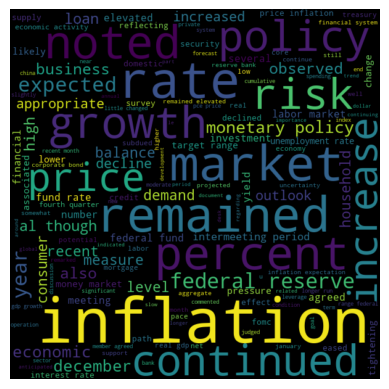

In [21]:
words = " ".join(df['paragraph'])
wordcloud = WordCloud(height = 600, width = 600,max_font_size = 100, max_words = 150,stopwords=stop_words).generate(words)
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words='english')
dtm = tfidf.fit_transform(df['paragraph'])

In [23]:
from sklearn.decomposition import NMF
nmf_model = NMF(n_components = 6, random_state =42)
nmf_model.fit(dtm)
nmf_model.components_[0].argsort()

for component in range(len(nmf_model.components_)):
    print(f'THE TOP 10 WORDS FOR TOPIC #{component}')
    print([tfidf.get_feature_names_out()[i] for i in nmf_model.components_[component].argsort()[-10:]])
    print('\n')
    

THE TOP 10 WORDS FOR TOPIC #0
['month', 'percent', 'gdp', 'core', 'expected', 'real', 'year', 'growth', 'price', 'inflation']


THE TOP 10 WORDS FOR TOPIC #1
['mortgage', 'business', 'bond', 'bank', 'household', 'january', 'quality', 'remained', 'credit', 'loan']


THE TOP 10 WORDS FOR TOPIC #2
['dallas', 'february', 'bank', 'governor', 'effective', 'return', 'federal', 'reserve', 'text', 'board']


THE TOP 10 WORDS FOR TOPIC #3
['federal', 'reserve', 'treasury', 'intermeeting', 'period', 'rrp', 'rate', 'facility', 'money', 'market']


THE TOP 10 WORDS FOR TOPIC #4
['economic', 'risk', 'appropriate', 'outlook', 'committee', 'stance', 'monetary', 'member', 'inflation', 'policy']


THE TOP 10 WORDS FOR TOPIC #5
['rate', 'bank', 'taking', 'sufficiently', 'primary', 'basis', 'approval', 'board', 'action', 'voting']




In [24]:
topic_results = nmf_model.transform(dtm)

In [25]:
topic_results.argmax(axis=1)

array([3, 2, 4, 3, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 3, 4, 4, 4,
       4, 3, 4, 4, 4, 2, 2, 5, 5, 2, 2, 2, 0, 2, 2, 2, 2, 2])

In [26]:
df['Topic'] = topic_results.argmax(axis = 1)

In [32]:
dict = {0 :'Financial Markets' ,
        1 :'Interest rates',
        2 :'Decision making',
        3 :'Inflation causes',
       4:'Managing inflation',
       5: 'Policy considerations'}

In [33]:
df['Topic Label'] = df['Topic'].map(dict)

In [34]:
df.head(10)

,paragraph,Topic,Topic Label
78,part annual review committee's governance docu...,3,Inflation causes
79,ahead vote policy relating information securit...,2,Decision making
80,part committee's annual organizational review ...,4,Managing inflation
81,development financial market open market opera...,3,Inflation causes
82,moderating inflation united state improving gl...,0,Financial Markets
83,regarding international outlook sign faster re...,3,Inflation causes
84,manager pro tem turned next discussion money m...,3,Inflation causes
85,manager noted coming month development affecti...,3,Inflation causes
86,unanimous vote ratified desk's domestic transa...,3,Inflation causes
87,review economic situationthe information avail...,0,Financial Markets


In [35]:
import seaborn as sns

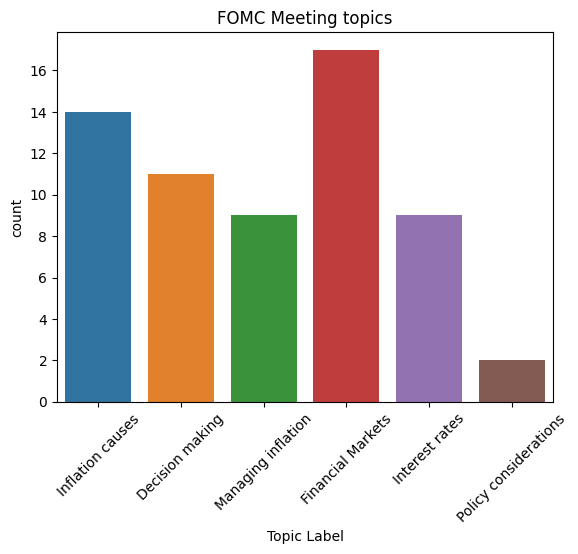

In [39]:
sns.countplot(x = df['Topic Label'])
plt.xticks(rotation = 45)
plt.title('FOMC Meeting topics')
plt.show()